# Document Analysis Using Vision LLMs

This system can do the following:
- Process image documents
- Extract text from image documents using Vision LLMs
- Perform calculations when needed (using tools)
- Analyze the content and provide concise summaries
- Execute specific instructions related to documents

In [1]:
# Built-in library
import asyncio
import json
import logging
import re
import warnings
from pathlib import Path
from pprint import pprint
from typing import (
    Annotated,
    Any,
    Generator,
    Iterable,
    Literal,
    Optional,
    TypedDict,
    Union,
)

# Standard imports
import nest_asyncio
import numpy as np
import numpy.typing as npt
import pandas as pd
import polars as pl
from rich.console import Console
from rich.theme import Theme

custom_theme = Theme(
    {
        "white": "#FFFFFF",  # Bright white
        "info": "#00FF00",  # Bright green
        "warning": "#FFD700",  # Bright gold
        "error": "#FF1493",  # Deep pink
        "success": "#00FFFF",  # Cyan
        "highlight": "#FF4500",  # Orange-red
    }
)
console = Console(theme=custom_theme)

# Visualization
# import matplotlib.pyplot as pltife

# NumPy settings
np.set_printoptions(precision=4)

# Pandas settings
pd.options.display.max_rows = 1_000
pd.options.display.max_columns = 1_000
pd.options.display.max_colwidth = 600

# Polars settings
pl.Config.set_fmt_str_lengths(1_000)
pl.Config.set_tbl_cols(n=1_000)

warnings.filterwarnings("ignore")

# Black code formatter (Optional)
%load_ext lab_black

# auto reload imports
%load_ext autoreload
%autoreload 2

In [2]:
def go_up_from_current_directory(*, go_up: int = 1) -> None:
    """This is used to up a number of directories.

    Params:
    -------
    go_up: int, default=1
        This indicates the number of times to go back up from the current directory.

    Returns:
    --------
    None
    """
    import os
    import sys

    CONST: str = "../"
    NUM: str = CONST * go_up

    # Goto the previous directory
    prev_directory = os.path.join(os.path.dirname(__name__), NUM)
    # Get the 'absolute path' of the previous directory
    abs_path_prev_directory = os.path.abspath(prev_directory)

    # Add the path to the System paths
    sys.path.insert(0, abs_path_prev_directory)
    print(abs_path_prev_directory)

In [3]:
go_up_from_current_directory(go_up=2)


from schemas import ModelEnum  # noqa: E402
from settings import refresh_settings  # noqa: E402
from utilities.utilities import async_retrying_with_print, simple_retry

settings = refresh_settings()

/Users/neidu/Desktop/Projects/Personal/My_Projects/AI-Tutorials


In [4]:
from typing import Callable, List


def chunk_document(
    sentences: List[str],
    max_tokens_per_chunk: int,
    overlap_size: int = 2,
    get_token_count: Callable[[str], int] = lambda text: len(
        text.split()
    ),  # Simple token counter
) -> List[List[str]]:
    """
    Chunk a document into smaller chunks based on sentence boundaries while respecting
    maximum tokens per chunk constraint.

    Parameters
    ----------
    sentences : List[str]
        List of sentences from the document
    max_tokens_per_chunk : int
        Maximum number of tokens allowed in a chunk
    overlap_size : int, optional
        Number of sentences to overlap between adjacent chunks, default 2
    get_token_count : callable, optional
        Function to count tokens in text, defaults to simple word splitting

    Returns
    -------
    List[List[str]]
        List of chunks, where each chunk is a list of sentences
    """
    if not sentences:
        return []

    # Calculate token count for each sentence
    sentence_token_counts = [get_token_count(sentence) for sentence in sentences]

    # Check if any individual sentence exceeds the token limit
    max_sentence_tokens = max(sentence_token_counts)
    if max_sentence_tokens > max_tokens_per_chunk:
        print(
            f"Warning: Some sentences exceed the token limit ({max_sentence_tokens} > {max_tokens_per_chunk})"
        )
        print(
            "These sentences will be placed in their own chunks, exceeding the token limit."
        )

    # Create chunks based solely on token limit
    chunks = []
    current_chunk = []
    current_token_count = 0

    for sentence, token_count in zip(sentences, sentence_token_counts, strict=True):
        # If adding this sentence would exceed the limit and we already have sentences in the chunk,
        # finalize the current chunk and start a new one
        if current_token_count + token_count > max_tokens_per_chunk and current_chunk:
            chunks.append(current_chunk)
            current_chunk = []
            current_token_count = 0

        # Add the sentence to the current chunk
        current_chunk.append(sentence)
        current_token_count += token_count

    # Add the last chunk if not empty
    if current_chunk:
        chunks.append(current_chunk)

    # Create overlapping chunks
    overlapping_chunks = []

    for i in range(len(chunks)):
        if i < len(chunks) - 1:
            # Get overlap from next chunk
            next_chunk_overlap = chunks[i + 1][: min(overlap_size, len(chunks[i + 1]))]

            # Calculate token count with overlap
            current_with_overlap = chunks[i] + next_chunk_overlap
            total_tokens_with_overlap = sum(
                get_token_count(s) for s in current_with_overlap
            )

            # Check if adding overlap exceeds token limit
            if total_tokens_with_overlap <= max_tokens_per_chunk:
                overlapping_chunks.append(current_with_overlap)
            else:
                # If too large, don't add overlap or add partial overlap if possible
                partial_overlap = []
                remaining_tokens = max_tokens_per_chunk - sum(
                    get_token_count(s) for s in chunks[i]
                )

                for overlap_sentence in next_chunk_overlap:
                    overlap_tokens = get_token_count(overlap_sentence)
                    if remaining_tokens >= overlap_tokens:
                        partial_overlap.append(overlap_sentence)
                        remaining_tokens -= overlap_tokens
                    else:
                        break

                if partial_overlap:
                    overlapping_chunks.append(chunks[i] + partial_overlap)
                else:
                    overlapping_chunks.append(chunks[i])
        else:
            # Last chunk, no overlap to add
            overlapping_chunks.append(chunks[i])

    return overlapping_chunks


# Example usage:
if __name__ == "__main__":
    # Example document (list of sentences)
    sample_sentences = [
        "This is sentence one with several tokens.",
        "Here is another sentence that is quite long and has many tokens for demonstration.",
        "This is a short one.",
        "The algorithm needs to handle varying sentence lengths effectively.",
        "Some sentences might have a lot of tokens and be very informative requiring significant processing.",
        "Others might be brief.",
        "We need to ensure that no chunk exceeds the token limit.",
        "At the same time, we want to maintain context between chunks using overlaps.",
        "Overlapping sentences help maintain context between chunks.",
        "This is the last sentence of our example.",
    ]

    # Example constraint
    MAX_TOKENS = 77  # Max tokens per chunk

    # Get chunks
    chunks = chunk_document(sentences=sample_sentences, max_tokens_per_chunk=MAX_TOKENS)

    # Print results
    print(f"Created {len(chunks)} chunks:")
    for i, chunk in enumerate(chunks):
        token_count = sum(len(s.split()) for s in chunk)
        print(f"Chunk {i + 1}: {len(chunk)} sentences, {token_count} tokens")
        print("  " + "\n  ".join(chunk))
        print()

Created 2 chunks:
Chunk 1: 7 sentences, 65 tokens
  This is sentence one with several tokens.
  Here is another sentence that is quite long and has many tokens for demonstration.
  This is a short one.
  The algorithm needs to handle varying sentence lengths effectively.
  Some sentences might have a lot of tokens and be very informative requiring significant processing.
  Others might be brief.
  We need to ensure that no chunk exceeds the token limit.

Chunk 2: 3 sentences, 28 tokens
  At the same time, we want to maintain context between chunks using overlaps.
  Overlapping sentences help maintain context between chunks.
  This is the last sentence of our example.



In [5]:
sample_sentences: list[str] = [
    "My name is Jon Doe. ",
    "I live in SF. ",
    "I have a 1 year old daughter. ",
    "Thanks for letting me know that uv add pip fixed the issue! That makes sense. It "
    "indicates you were likely using uv (a fast Python package installer and resolver) "
    "to manage your environment. ",
    "God is love. ",
    "G.O.A.T. That guy is a legend!",
]

# Example constraints
MAX_TOKENS = 20  # Max tokens per chunk

# Get chunks
chunks = chunk_document(
    sentences=sample_sentences,
    max_tokens_per_chunk=MAX_TOKENS,
    overlap_size=3,
)

# Print results
print(f"Created {len(chunks)} chunks:")
for i, chunk in enumerate(chunks):
    token_count = sum(len(s.split()) for s in chunk)
    print(f"Chunk {i + 1}: {len(chunk)} sentences, {token_count} tokens")
    print("  " + "\n  ".join(chunk))
    print()

These sentences will be placed in their own chunks, exceeding the token limit.
Created 3 chunks:
Chunk 1: 3 sentences, 16 tokens
  My name is Jon Doe. 
  I live in SF. 
  I have a 1 year old daughter. 

Chunk 2: 1 sentences, 33 tokens
  Thanks for letting me know that uv add pip fixed the issue! That makes sense. It indicates you were likely using uv (a fast Python package installer and resolver) to manage your environment. 

Chunk 3: 2 sentences, 9 tokens
  God is love. 
  G.O.A.T. That guy is a legend!



In [6]:
import base64

from IPython.display import Image, display
from langchain.chat_models import init_chat_model
from langchain_core.messages import AnyMessage, HumanMessage, SystemMessage
from langchain_litellm import ChatLiteLLM
from langgraph.graph import END, START, StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

In [7]:
import anyio


async def aencode_image_to_base64(image_path: str) -> str:
    """
    Asynchronously encode an image file to base64 string.

    Parameters
    ----------
    image_path : str
        Path to the image file.

    Returns
    -------
    str
        Base64 encoded string of the image.
    """
    image_path: Path = Path(image_path)
    async with await anyio.open_file(image_path, "rb") as f:
        image_data: bytes = await f.read()
        image_base64: str = base64.b64encode(image_data).decode("utf-8")
        return image_base64


class State(TypedDict):
    """State class to store input file and messages."""

    input_file: str | None
    messages: Annotated[list[AnyMessage], add_messages]


# ==============================================
# TOOLS
# ==============================================


async def extract_text(image_path: str) -> str:
    """Extract text from an image file using a Vision Language Model.

    Parameters
    ----------
    image_path : str
        Path to the image file.

    Returns
    -------
    str
        Extracted text from the image, empty string if error occurs.

    Global Variables
    ---------------
    vision_llm : Any
        Vision language model instance.
    """
    global vision_llm

    all_text: str = ""
    try:
        image_base64 = await aencode_image_to_base64(image_path)

        # Prepare the prompt with the base64 image data
        message = [
            HumanMessage(
                content=[
                    {
                        "type": "text",
                        "text": "Extract all the text from this image. Return only "
                        "the extracted text with no explanations.",
                    },
                    {
                        "type": "image_url",
                        "image_url": {
                            "url": f"data:image/png;base64,{image_base64}",
                        },
                    },
                ]
            )
        ]
        # Call the VLM to extract text
        response = await vision_llm.ainvoke(message)
        all_text += response.content + "\n\n"

        return all_text.strip()
    except Exception as e:
        print(f"Error extracting text from image {image_path}: {e}")
        return ""  # Return empty string on error


def divide(a: float, b: float) -> float:
    """Divide two numbers.

    Parameters
    ----------
    a : float
        Numerator.
    b : float
        Denominator.

    Returns
    -------
    float
        Result of division rounded to 4 decimal places.

    Raises
    ------
    ValueError
        If denominator is zero.
    """
    if b == 0:
        raise ValueError("Cannot divide by zero.")
    return round((a / b), 4)


# ==============================================
# NODES
# ==============================================
async def assistant(state: State) -> dict[str, Any]:
    """Process state and generate assistant response using LLM.

    This function takes a state object containing messages and input file,
    generates a system message with tool descriptions, and invokes the LLM
    to get a response.

    Parameters
    ----------
    state : State
        State object containing:
            messages : list[Message]
                List of conversation messages
            input_file : str
                Path to input image file

    Returns
    -------
    dict[str, Any]
        Dictionary containing:
            messages : list[Message]
                List with the LLM response message
            input_file : str
                Path to input image file

    Global Variables
    ---------------
    llm_with_tools : Any
        LLM instance configured with tools
    """
    global llm_with_tools

    textual_description_of_tool: str = """
    extract_text(image_path: str) -> str
        Extract text from an image file using a Vision Language Model.

        Parameters
        ----------
        image_path : str
            Path to the image file.

        Returns
        -------
        str
            Extracted text from the image, empty string if error occurs.

        Global Variables
        ---------------
        vision_llm : Any
            Vision language model instance.
    divide(a: float, b: float) -> float
        Divide two numbers.

        Parameters
        ----------
        a : float
            Numerator.
        b : float
            Denominator.

        Returns
        -------
        float
            Result of division rounded to 4 decimal places.

        Raises
        ------
        ValueError
            If denominator is zero.
    """
    image: str = state["input_file"]
    sys_msg: SystemMessage = SystemMessage(
        content=f"You're a helpful butler named Alfred that serves Mr. Neidu "
        f"and Batman. You can analyze documents and run computations with "
        f"provided tools: \n{textual_description_of_tool} You have access "
        f"to some optional images. Currently, the loaded image is: {image}"
    )
    response: Any = await llm_with_tools.ainvoke([sys_msg] + state["messages"])
    return {"messages": [response], "input_file": image}


tools = [extract_text, divide]
tool_node = ToolNode(tools=tools)

### The ReAct Pattern

- Re: React to the user's input.
- Act: Act on the user's input by using the appropriate tools.
- Observe the results of the tools and provide feedback to the user.
- Reapeat as necessary until the user is satisfied.

In [8]:
# LLM and VLM
llm = init_chat_model(model="mistralai:mistral-large-latest", temperature=0.3)
llm_with_tools = llm.bind_tools(tools)

vision_llm = init_chat_model(
    model="mistralai:pixtral-large-latest",
    temperature=0.3,
)

graph_builder = StateGraph(State)

# Add nodes
graph_builder.add_node("assistant", assistant)
graph_builder.add_node("tools", tool_node)

# Connect nodes
graph_builder.add_edge(START, "assistant")
graph_builder.add_conditional_edges("assistant", tools_condition)
graph_builder.add_edge("tools", "assistant")
graph_builder.add_edge("assistant", END)

# Compile the graph
graph = graph_builder.compile()

### Visualize

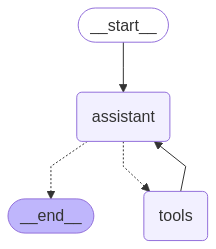

In [9]:
# Visualize the graph
display(Image(graph.get_graph().draw_mermaid_png()))

<br>

### Example 1: Simple Calculations

In [16]:
from functools import wraps
import nest_asyncio
import asyncio

nest_asyncio.apply()


@simple_retry(attempts=3, delay=1, timeout=60)
async def unstable_function() -> str:
    """An example unstable function that may fail."""
    import random

    if random.random() < 0.9:  # 50% chance to raise an error
        raise ValueError("Simulated failure")
    return "Function executed successfully"

In [17]:
await unstable_function()

Attempt 1...
Completed attempt 1
Attempt 2...
Completed attempt 2
Attempt 3...
Completed attempt 3
Failed after 3 attempts: Simulated failure


In [22]:
@simple_retry(attempts=3, delay=1, timeout=60)
async def run_graph(messages: list[Any], input_file: str | None) -> None:
    """Run the graph with the initial messages."""
    messages = await graph.ainvoke({"messages": messages, "input_file": input_file})

    # Show the messages
    for message in messages["messages"]:
        # console.log(message)
        message.pretty_print()

In [23]:
messages = [HumanMessage(content="Divide 6790 by 5")]
input_file = None  # No input file for this example

await run_graph(messages=messages, input_file=input_file)

Attempt 1...
================================ Human Message =================================

Divide 6790 by 5
================================== Ai Message ==================================
Tool Calls:
  divide (5E9pCzuOj)
 Call ID: 5E9pCzuOj
  Args:
    a: 6790
    b: 5
================================= Tool Message =================================
Name: divide

1358.0
================================== Ai Message ==================================

The result of dividing 6790 by 5 is 1358.0.


### Example 2: Analyzing Training Documents

In [24]:
messages = [
    HumanMessage(
        content="According tho the note provided by Mr. Wayne in the "
        "provided images, what is the list of items I should buy for "
        "the dinner menu?"
    )
]
input_file: str = "../../data/Batman_training_and_meals.png"

await run_graph(messages=messages, input_file=input_file)

Attempt 1...
================================ Human Message =================================

According tho the note provided by Mr. Wayne in the provided images, what is the list of items I should buy for the dinner menu?
================================== Ai Message ==================================
Tool Calls:
  extract_text (08Dj5DwgH)
 Call ID: 08Dj5DwgH
  Args:
    image_path: ../../data/Batman_training_and_meals.png
================================= Tool Message =================================
Name: extract_text

### TRAINING SCHEDULE

For the week of 2/20-2/26

**SUNDAY 2/20**

**MORNING**
30 minute jog
30 minute meditation

**EVENING**
clean and jerk (lite)—3 rep/8 sets, 262 lbs.
5 sets metabolic conditioning
21 kettlebell swings
12 pull-ups
30 minutes flexibility
30 minutes sparring

**MONDAY 2/21**

**MORNING**
30 minute jog
30 minutes traditional kata (focus on Japanese forms)

**EVENING**
5 sets 20 ft rope climb
30 minutes gymnastic rings (work on muscle ups in high ba

In [ ]:
# TODO: 
# - Add more tools for different tasks
# - Implement error handling for tool failures
# - Add memory to store previous messages and results